# Retrieve


We want to download the monthly precipitation for February. I use the automatically generated request from the CDS server. There are two datasets we can use to download the data: [Seasonal forecast daily data on single levels](https://cds.climate.copernicus.eu/cdsapp#!/dataset/seasonal-original-single-levels?tab=form) and [Seasonal forecast monthly statistics on single levels](https://cds.climate.copernicus.eu/cdsapp#!/dataset/seasonal-monthly-single-levels?tab=form). We will use the latter for easy downloading of the monthly values. If we want to go to higher temporal resolution, such as daily extremes, we will have to consult the other dataset. 

To get started with CDS, you have to register at https://cds.climate.copernicus.eu/ and copy your UID and API key from https://cds.climate.copernicus.eu/user in the  `~/.cdsapirc`  file in the home directory of your user. See the [ml-flood project](https://nbviewer.jupyter.org/github/esowc/ml_flood/blob/master/notebooks/1_data_download_analysis_visualization/1.01_cdsapi_setup.ipynb) for more details


In [7]:
UID = 'UID'
API_key = 'API_key'

In [8]:
import os 
#Uncomment the following lines to write the UID and API key in the .cdsapirc file
# with open(os.path.join(os.path.expanduser('~'), '.cdsapirc'), 'w') as f:
#     f.write('url: https://cds.climate.copernicus.eu/api/v2\n')
#     f.write(f'key: {UID}:{API_key}')

46

47

### Import packages

In [1]:
##This is so variables get printed within jupyter
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

In [2]:
##import packages
import os
import cdsapi ## check the current working directory, which should be the UNSEEN-open directory
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy
import cartopy.crs as ccrs

In [3]:
##We want the working directory to be the UNSEEN-open directory
pwd = os.getcwd() ##current working directory is UNSEEN-open/Notebooks/1.Download
pwd #print the present working directory
os.chdir(pwd+'/../../../') # Change the working directory to UNSEEN-open
os.getcwd() #print the working directory

'C:\\Users\\Timo\\OneDrive - Loughborough University\\GitHub\\UNSEEN-open\\doc\\Notebooks\\1.Download'

'C:\\Users\\Timo\\OneDrive - Loughborough University\\GitHub\\UNSEEN-open\\doc'

### First download

In our request, we will use the monthly mean. Interestingly, there is also the option to use the monthly maximum! We previously downloaded the data on daily resolution and extracted the monthly (or seasonal) maximum from that data. If we could just download the monthly maximum instead that might save a lot of processing power! However, you would be restricted to daily extremes only, for multi-day extremes (5 days is often used), you would have to do the original processing workflow. We select the UK domain to reduce the size of the download.

Here I download the monthly mean total precipitation (both convective and large scale precipitation) forecast for February 1993. It downloads all 25 ensemble members for the forecasts initialized in january.    

In [4]:
##Our first download:

c = cdsapi.Client()

c.retrieve(
    'seasonal-monthly-single-levels',
    {
        'format': 'netcdf',
        'originating_centre': 'ecmwf',
        'system': '5',
        'variable': 'total_precipitation',
        'product_type': [
            'monthly_mean', #'monthly_maximum',, 'monthly_standard_deviation',  
        ],
        'year': '1993', #data before 1993 is available.  
        'month': '01', #Initialization month. Target month is February (2), initialization months are August-January (8-12,1)
        'leadtime_month': [ ##Use of single months is much faster. Leadtime 0 does not exist. The first lead time is 1.
            '1', '2',
        ],
        'area': [##Select UK domain to reduce the size of the download
            60, -11, 50,
            2,
        ],
    },
    'Data/First_download.nc') ##can I use nc? yes! 

2020-05-13 10:08:56,140 INFO Welcome to the CDS
2020-05-13 10:08:56,142 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-monthly-single-levels
2020-05-13 10:08:56,983 INFO Request is completed
2020-05-13 10:08:56,984 INFO Downloading http://136.156.132.110/cache-compute-0001/cache/data0/adaptor.mars.external-1589266964.5635436-26283-29-a38e8975-b0ec-49ee-8f9b-7dea389f59cf.nc to Data/First_download.nc (16.4K)
2020-05-13 10:08:57,131 INFO Download rate 112.7K/s


Result(content_length=16800,content_type=application/x-netcdf,location=http://136.156.132.110/cache-compute-0001/cache/data0/adaptor.mars.external-1589266964.5635436-26283-29-a38e8975-b0ec-49ee-8f9b-7dea389f59cf.nc)

## Use xarray to visualize the netcdf file

I open the downloaded file and plot February 1993 precipitation over the UK. 

In [5]:
pr_1993_ds=xr.open_dataset('Data/First_download.nc')
pr_1993_ds


<xarray.Dataset>
Dimensions:    (latitude: 11, longitude: 14, number: 25, time: 2)
Coordinates:
  * longitude  (longitude) float32 -11.0 -10.0 -9.0 -8.0 ... -1.0 0.0 1.0 2.0
  * latitude   (latitude) float32 60.0 59.0 58.0 57.0 ... 53.0 52.0 51.0 50.0
  * number     (number) int32 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01
Data variables:
    tprate     (time, number, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-05-12 07:02:45 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

I select ensemble member 0 and february precipitation ('tprate' called apparently) and I use cartopy to make the map. 

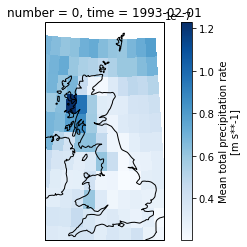

In [6]:
## Use cartopy for nicer maps
ax = plt.axes(projection= ccrs.OSGB()) 
pr_1993_ds['tprate'].sel(number=0,time='1993-02').plot(transform=ccrs.PlateCarree(),cmap=plt.cm.Blues, ax=ax)  #,cmap=plt.cm.Blues,

# ax.set_extent(extent)
ax.coastlines(resolution='50m')
plt.draw()

## Download all data

We will be using the SEAS5 hindcast, which is a dataset running from 1981-2016. The hindcast is initialized every month with 25 ensemble members and the forecast run for 6 months, indicated by blue horizontal bars below. February is forecasted by 6 initialization months (September-February). We discard the first month of the forecast because of dependence between the forecasts, explained in the evaluation section and are left with 5 initialization months (Sep-Jan) and 25 ensemble members forecasting february precipitation each year, totalling to an increase of 125 times the observed length.

For a summary of all available C3S seasonal hindcasts, their initialization months and more specifics, please see [ECMWF page](https://confluence.ecmwf.int/display/CKB/C3S+Seasonal+Forecasts) and the [SEAS5 paper](https://doi.org/10.5194/gmd-12-1087-2019).  



![title](../../../graphs/Data_illustration.png)

The first download example above downloaded all 25 ensemble members for the forecast initialized in January (the bottom bar). We should repeat this over the other initialization month and over all years (1981-2016).

In [58]:
init_months = np.append(np.arange(9,13),1) ## Initialization months 9-12,1 (Sep-Jan)
init_months 
years = np.arange(1982,2017)
years


array([ 9, 10, 11, 12,  1])

array([1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016])

For our download, we loop over initialization months and years. Because we only want February precipitation, the leadtime month (forecast length) changes with the initialization month. For example, in the September initialized forecasts, we only want the leadtime month 6 = February. For August initialized this is leadtime 5, etc. Furthermore, the year the forecast is initialized is required for the download. For September - December initialized forecasts, this is the target year-1. For January it is the same year as the target year. For example, for the first two target years this looks like the following:

In [101]:

for j in range(2):#len(years)):
    for i in range(len(init_months)):
        init_month = init_months[i]
        leadtime_month = 6-i
        if init_month == 1:
            year = years[j]
        else:
            year = years[j]-1
        print ('year = ' + str(year) +' init_month = ' + str(init_month) + ' leadtime_month = ' + str(leadtime_month))

year = 1981 init_month = 9 leadtime_month = 6
year = 1981 init_month = 10 leadtime_month = 5
year = 1981 init_month = 11 leadtime_month = 4
year = 1981 init_month = 12 leadtime_month = 3
year = 1982 init_month = 1 leadtime_month = 2
year = 1982 init_month = 9 leadtime_month = 6
year = 1982 init_month = 10 leadtime_month = 5
year = 1982 init_month = 11 leadtime_month = 4
year = 1982 init_month = 12 leadtime_month = 3
year = 1983 init_month = 1 leadtime_month = 2


Write a function that is used for the download.

In [72]:
def retrieve(variable, originating_centre, year, init_month, leadtime_month):
    
    c.retrieve(
        'seasonal-monthly-single-levels',
        {
            'format': 'netcdf',
            'originating_centre': originating_centre,
            'system': '5',
            'variable': variable,
            'product_type': [
                'monthly_mean', #'monthly_maximum',, 'monthly_standard_deviation',  
            ],
            'year': str(year), #data before 1993 is available.  
            'month': "%.2i" % init_month, #Initialization month. Target month is February (2), initialization months are August-January (8-12,1)
            'leadtime_month': [ ##The lead times you want. Use of single months is much faster. Leadtime 0 does not exist. The first lead time is 1.
                #For initialization month 1 (January), the leadtime months is 2 (February). For initialization month 12 (december), the lead time month is 3 (February).
                str(leadtime_month),
            ],
            'area': [##Select UK domain to reduce the size of the download
                     ## 25N-75N x. 40W-75E
                60, -11, 50, 2,
            ],
        },
        '../UK_example/'+ str(year) + "%.2i" % init_month + '.nc')
    
# retrieve(variable = 'total_precipitation',originating_centre = 'ecmwf', year = years[0], init_month = "%.2i" % init_months[0])
    
    

And start the download! In total, we request 35 years x  initialization dates = 175 requests. 
I could try sending just 5 request of the different initialization dates for all years?

In [ ]:
for j in range(len(years)):  ##add if error still continue
    for i in range(len(init_months)):
        init_month = init_months[i]
        leadtime_month = 6 - i
        if init_month == 1:
            year = years[j]
        else:
            year = years[j] - 1
        retrieve(variable='total_precipitation',
                 originating_centre='ecmwf',
                 year=year,
                 init_month=init_month,
                 leadtime_month=leadtime_month)

2020-05-18 10:14:48,767 INFO Welcome to the CDS
2020-05-18 10:14:48,768 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-monthly-single-levels
2020-05-18 10:14:49,485 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data5/adaptor.mars.external-1589380912.7108843-4209-7-1add31ae-a0cd-44ce-83ac-9ff7c97f1b01.nc to ../UK_example/198109.nc (8.9K)
2020-05-18 10:14:49,575 INFO Download rate 101.5K/s
2020-05-18 10:14:49,803 INFO Welcome to the CDS
2020-05-18 10:14:49,804 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-monthly-single-levels
2020-05-18 10:14:50,498 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data4/adaptor.mars.external-1589381056.172494-12462-1-c9714216-87ac-49bc-be19-260627a9077d.nc to ../UK_example/198110.nc (8.9K)
2020-05-18 10:14:50,571 INFO Download rate 124.6K/s
2020-05-18 10:14:51,070 INFO Welcome to the CDS
2020-05-18 10:14:51,071 INFO Sending request to https://cd

The download sometimes fails. When redoing the request it does download. I don't know what is causing the failure? Below I donwload the file that failed. 

In [97]:
#201501 missing

year = 2015 
init_month = 1 
leadtime_month = 2
retrieve(variable = 'total_precipitation',originating_centre = 'ecmwf', year = year, 
                 init_month = init_month, leadtime_month = leadtime_month)



2020-05-15 11:51:16,127 INFO Welcome to the CDS
2020-05-15 11:51:16,129 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/seasonal-monthly-single-levels
2020-05-15 11:51:16,327 INFO Downloading http://136.156.133.46/cache-compute-0015/cache/data7/adaptor.mars.external-1589527607.2123153-8094-37-3b786f72-2e2a-462f-bbb8-9c8d89c05102.nc to ../UK_example/201501.nc (8.9K)
2020-05-15 11:51:16,485 INFO Download rate 56.7K/s


## Retrieve function
We have written a module where the above procedure is done automatically. 
Here we load the retrieve module and retrieve SEAS5 and ERA5 data for [the examples](../examples.rst) by selecting the variable, target month(s), area and folder where we want to download the file in. 

In [3]:
import os
import sys
sys.path.insert(0, os.path.abspath('../../../'))
os.chdir(os.path.abspath('../../../'))

import src.cdsretrieve as retrieve
import src.preprocess as preprocess

import numpy as np
import xarray as xr

The main function to download the data is `retrieve.retrieve_SEAS5`. The function only downloads the target months, for each year and each intialization month. To do this, it obtains the initialization months and leadtimes from the selected target month(s). For the UK example, we select February as our target month, hence sep-jan will be our initialization months with leadtimes 2-6, see [Download all](#Download-all-data). 

In [7]:
retrieve.print_arguments([2])

year = 1982 init_month = 1 leadtime_month = [2]
year = 1981 init_month = 12 leadtime_month = [3]
year = 1981 init_month = 11 leadtime_month = [4]
year = 1981 init_month = 10 leadtime_month = [5]
year = 1981 init_month = 9 leadtime_month = [6]


For the Siberia example this will be different, since the target months are march-may:

In [8]:
retrieve.print_arguments([3,4,5])

year = 1982 init_month = 2 leadtime_month = [2 3 4]
year = 1982 init_month = 1 leadtime_month = [3 4 5]
year = 1981 init_month = 12 leadtime_month = [4 5 6]


Call `?retrieve.retrieve_SEAS5` to see the documentation.

For the California example, we use:

In [ ]:
retrieve.retrieve_SEAS5(
    variables=['2m_temperature', '2m_dewpoint_temperature'],
    target_months=[8],
    area=[70, -130, 20, -70],
    years=np.arange(1981, 2021),
    folder='E:/PhD/California_example/SEAS5/')

In [ ]:
retrieve.retrieve_ERA5(variables=['2m_temperature', '2m_dewpoint_temperature'],
                       target_months=[8],
                       area=[70, -130, 20, -70],
                       folder='E:/PhD/California_example/SEAS5/')

For the Siberia example:

In [ ]:
retrieve.retrieve_SEAS5(
    variables=['2m_temperature', '2m_dewpoint_temperature'],
    target_months=[3, 4, 5],
    area=[70, -11, 30, 120],
    years=np.arange(1981, 2021),
    folder='../Siberia_example/SEAS5/')

In [ ]:
retrieve.retrieve_ERA5(variables = ['2m_temperature','2m_dewpoint_temperature'],
                       target_months = [3,4,5],
                       area = [70, -11, 30, 120],
                       folder = '../Siberia_example/ERA5/')

And for the UK example:

In [ ]:
retrieve.retrieve_SEAS5(variables = 'total_precipitation', 
                        target_months = [2],
                        area = [60, -11, 50, 2], 
                        folder = '../UK_example/SEAS5/')

In [ ]:
retrieve.retrieve_ERA5(variables = 'total_precipitation', 
                       target_months = [2],
                       area = [60, -11, 50, 2], 
                       folder = '../UK_example/ERA5/')

## EOBS data download

I tried to download EOBS through CDS, but the Product is temporally disabled for maintenance purposes (see below). As workaround I downloaded EOBS (from 1950 - 2019) and the most recent EOBS data (2020) [here](https://surfobs.climate.copernicus.eu/dataaccess/access_eobs.php). Note, you have to register as E-OBS user.

In [99]:
c.retrieve(
    'insitu-gridded-observations-europe',
    {
        'version': 'v20.0e',
        'format': 'zip',
        'product_type': 'ensemble_mean',
        'variable': 'precipitation_amount',
        'grid_resolution': '0_25',
        'period': 'full_period',
    },
    '../UK_example/EOBS/EOBS.zip')

2020-05-15 14:06:44,721 INFO Welcome to the CDS
2020-05-15 14:06:44,722 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-europe


Exception: Product temporally disabled for maintenance purposes. Sorry for the inconvenience, please try again later.